## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [10]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon) # p_t
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        cross_entropy = -tf.reduce_sum(y_true*tf.log(tf.clip_by_value(y_pred, 1e-10, 1.0)))  
            
        return 0.3*tf.reduce_mean(reduced_fl) + 0.7*(cross_entropy)
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [9]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00


W0725 21:14:11.453612 140276705179456 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 21:14:11.549076 140276705179456 deprecation.py:323] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

W0725 21:14:11.821422 140276705179456 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 108us/step - loss: 11026.8840 - acc: 0.1452 - val_loss: 15059.7692 - val_acc: 0.0703
Epoch 2/25
50000/50000 [==============================] - 4s 72us/step - loss: 13495.6997 - acc: 0.1805 - val_loss: 14759.0684 - val_acc: 0.0896
Epoch 3/25
50000/50000 [==============================] - 4s 72us/step - loss: 13363.4267 - acc: 0.1884 - val_loss: 14559.5999 - val_acc: 0.1018
Epoch 4/25
50000/50000 [==============================] - 4s 73us/step - loss: 13746.2823 - acc: 0.1651 - val_loss: 13873.6705 - val_acc: 0.1439
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 13562.4649 - acc: 0.1765 - val_loss: 13307.9169 - val_acc: 0.1793
Epoch 6/25
50000/50000 [==============================] - 5s 99us/step - loss: 13529.5189 - acc: 0.1785 - val_loss: 13572.5120 - val_acc: 0.1632
Epoch 7/25
50000/50000 [==============================] - 4s 89us/step - loss: 

Epoch 22/25
50000/50000 [==============================] - 6s 120us/step - loss: 767.7302 - acc: 0.6154 - val_loss: 1218.3037 - val_acc: 0.4501
Epoch 23/25
50000/50000 [==============================] - 7s 134us/step - loss: 755.9941 - acc: 0.6208 - val_loss: 1069.2215 - val_acc: 0.5043
Epoch 24/25
50000/50000 [==============================] - 7s 140us/step - loss: 740.9359 - acc: 0.6287 - val_loss: 1088.2465 - val_acc: 0.4825
Epoch 25/25
50000/50000 [==============================] - 6s 119us/step - loss: 729.1682 - acc: 0.6336 - val_loss: 1097.9589 - val_acc: 0.4790
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________________________________________________________

Epoch 8/25
50000/50000 [==============================] - 6s 111us/step - loss: 14170.5352 - acc: 0.1398 - val_loss: 14215.6995 - val_acc: 0.1239
Epoch 9/25
50000/50000 [==============================] - 8s 167us/step - loss: 14133.7681 - acc: 0.1421 - val_loss: 14004.1075 - val_acc: 0.1366
Epoch 10/25
50000/50000 [==============================] - 7s 135us/step - loss: 14158.6972 - acc: 0.1407 - val_loss: 13847.5351 - val_acc: 0.1464
Epoch 11/25
50000/50000 [==============================] - 5s 105us/step - loss: 14068.9830 - acc: 0.1460 - val_loss: 14402.2006 - val_acc: 0.1123
Epoch 12/25
50000/50000 [==============================] - 6s 112us/step - loss: 14170.7223 - acc: 0.1398 - val_loss: 14244.4785 - val_acc: 0.1220
Epoch 13/25
50000/50000 [==============================] - 7s 132us/step - loss: 14068.9826 - acc: 0.1461 - val_loss: 13800.9362 - val_acc: 0.1493
Epoch 14/25
50000/50000 [==============================] - 6s 128us/step - loss: 13958.7911 - acc: 0.1528 - val_loss: 13

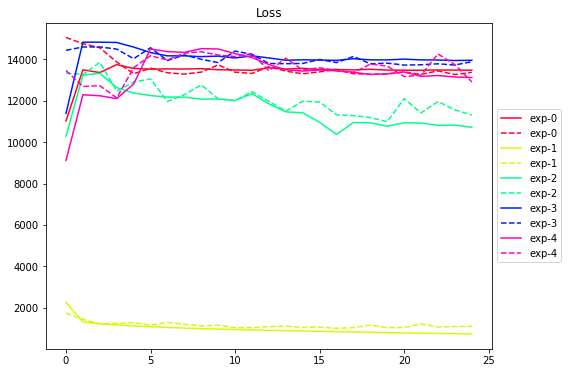

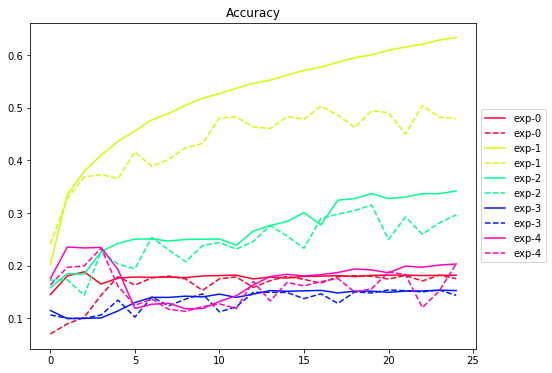

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()